In [36]:
import matplotlib.pyplot as plt
import gsd.hoomd
import numpy as np

In [37]:
def compute_all_flake_coms(flake_positions, box_lengths, beads_per_flake=50):
    Lx, Ly, Lz = box_lengths
    n_flakes = len(flake_positions) // beads_per_flake
    flake_coms = []

    for i in range(n_flakes):
        flake = flake_positions[i * beads_per_flake : (i + 1) * beads_per_flake]
        ref = flake[0]
        delta = flake - ref

        # Minimum image convention
        delta[:, 0] -= Lx * np.round(delta[:, 0] / Lx)
        delta[:, 1] -= Ly * np.round(delta[:, 1] / Ly)
        delta[:, 2] -= Lz * np.round(delta[:, 2] / Lz)

        unwrapped = ref + delta
        com = np.mean(unwrapped, axis=0)

        # Wrap CoM into [-L/2, L/2]
        com[0] = (com[0] + Lx/2) % Lx - Lx/2
        com[1] = (com[1] + Ly/2) % Ly - Ly/2
        com[2] = (com[2] + Lz/2) % Lz - Lz/2

        flake_coms.append(com)

    return np.array(flake_coms)

In [38]:
def count_clusters(flake_coms, box_lengths, cutoff, include_singletons=True):
    Lx, Ly, Lz = box_lengths
    n = len(flake_coms)
    adjacency = [set() for _ in range(n)]

    for i in range(n):
        for j in range(i + 1, n):
            dr = flake_coms[j] - flake_coms[i]
            dr[0] -= Lx * np.round(dr[0] / Lx)
            dr[1] -= Ly * np.round(dr[1] / Ly)
            dr[2] -= Lz * np.round(dr[2] / Lz)
            if np.linalg.norm(dr) < cutoff:
                adjacency[i].add(j)
                adjacency[j].add(i)

    visited = set()
    clusters = []

    for i in range(n):
        if i not in visited:
            cluster = []
            stack = [i]
            while stack:
                cur = stack.pop()
                if cur not in visited:
                    visited.add(cur)
                    cluster.append(cur)
                    stack.extend(adjacency[cur] - visited)

            if include_singletons or len(cluster) > 1:
                clusters.append(cluster)

    return len(clusters), [len(c) for c in clusters], clusters

In [39]:
def analyze_clusters_over_time(traj, start=0, step=1000, cutoff=2.5, beads_per_flake=50):
    times = []
    n_clusters_list = []
    avg_cluster_sizes = []

    for frame_idx in range(start, len(traj), step):
        frame = traj[frame_idx]
        box_lengths = frame.configuration.box[:3]

        flake_type = "F"
        flake_typeid = frame.particles.types.index(flake_type)
        positions = frame.particles.position
        typeids = frame.particles.typeid
        flake_positions = positions[typeids == flake_typeid]

        flake_coms = compute_all_flake_coms(flake_positions, box_lengths, beads_per_flake)
        n_clusters, sizes, _ = count_clusters(flake_coms, box_lengths, cutoff)

        times.append(frame_idx)
        n_clusters_list.append(n_clusters)
        avg_cluster_sizes.append(np.mean(sizes) if sizes else 0)

    return times, n_clusters_list, avg_cluster_sizes

In [40]:
def autocorr1D(array):
    ft = np.fft.rfft(array - np.average(array))  
    acorr = np.fft.irfft(ft * np.conjugate(ft))  
    acorr /= (len(array) * np.var(array))        

    dt = np.where(acorr < 0)[0][0]               
    nsamples = len(array) // dt                  

    acorr = acorr[dt:nsamples]                  

    return nsamples, dt

In [41]:
start_range = 64
end_range = 72
increment_value = 1

In [42]:
def calculate_num_and_size_means_fd(chains):
    mean_dec_sizes = []
    mean_num_dec_clusters = []
    
    for i in range(70,360,10):
        new_dens = i/1000
        file_name_main = f"{chains}_10mer5f_0.005dt_1.0kT_0.001id_{new_dens}fd_500000.0ssteps_1000000.0rsteps"
        start_file = f"{file_name_main}_start.txt"
        traj_file = f"{file_name_main}.gsd"
        with open(start_file) as f:
            start = int(f.readlines()[0].strip()) # extracting post-shrink sim beginning frame
        traj = gsd.hoomd.open(traj_file)
        times, n_clusters, avg_sizes = analyze_clusters_over_time(
            traj,
            start=start,   # post-shrink
            step=1, # analyze every "x" frame, leave this at 1
            cutoff=4
        ) # this function is used to initially calculate the decorrelation time, so that we know every how many certain amount of frames to analyze. 
        
        n, dt = autocorr1D(avg_sizes)
    
        decorrelated_times = times[::dt]
        decorrelated_sizes = avg_sizes[::dt]
        decorrelated_clusters = n_clusters[::dt]
        
        mean_dec_sizes.append(np.mean(decorrelated_sizes))
        mean_num_dec_clusters.append(np.mean(decorrelated_clusters))
    return mean_dec_sizes, mean_num_dec_clusters

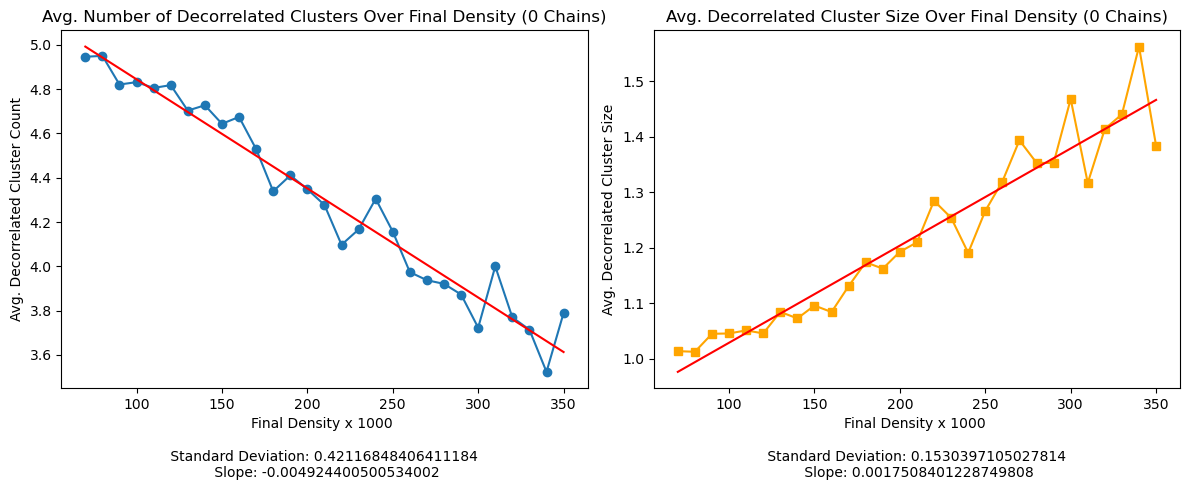

In [43]:
num_chains = 0

start_range = 70
end_range = 360
increment_value = 10

mean_dec_sizes, mean_num_dec_clusters = calculate_num_and_size_means_fd(num_chains)

num_slope, num_intercept = np.polyfit(range(start_range, end_range, increment_value), mean_num_dec_clusters, 1)
num_line_of_best_fit = num_slope * range(start_range, end_range, increment_value) + num_intercept

size_slope, size_intercept = np.polyfit(range(start_range, end_range, increment_value), mean_dec_sizes, 1)
size_line_of_best_fit = size_slope * range(start_range, end_range, increment_value) + size_intercept

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(start_range, end_range, increment_value), mean_num_dec_clusters, marker='o')
plt.plot(range(start_range, end_range, increment_value), num_line_of_best_fit, color='red')
plt.title(f"Avg. Number of Decorrelated Clusters Over Final Density ({num_chains} Chains)")
plt.xlabel(f"Final Density x 1000 \n \n Standard Deviation: {np.std(mean_num_dec_clusters)} \n Slope: {num_slope}")
plt.ylabel("Avg. Decorrelated Cluster Count")

plt.subplot(1, 2, 2)
plt.plot(range(start_range, end_range, increment_value), mean_dec_sizes, marker='s', color='orange')
plt.plot(range(start_range, end_range, increment_value), size_line_of_best_fit, color='red')
plt.title(f"Avg. Decorrelated Cluster Size Over Final Density ({num_chains} Chains)")
plt.xlabel(f"Final Density x 1000 \n \n Standard Deviation: {np.std(mean_dec_sizes)} \n Slope: {size_slope}")
plt.ylabel("Avg. Decorrelated Cluster Size")

plt.tight_layout()
plt.show()

In [46]:
def calculate_num_and_size_means_chains(chains):
    mean_dec_sizes = []
    mean_num_dec_clusters = []
    
    for i in range(chains,120,10):
        new_chains = i
        file_name_main = f"{new_chains}_10mer5f_0.005dt_1.0kT_0.001id_0.16fd_500000.0ssteps_1000000.0rsteps"
        start_file = f"{file_name_main}_start.txt"
        traj_file = f"{file_name_main}.gsd"
        with open(start_file) as f:
            start = int(f.readlines()[0].strip()) # extracting post-shrink sim beginning frame
        traj = gsd.hoomd.open(traj_file)
        times, n_clusters, avg_sizes = analyze_clusters_over_time(
            traj,
            start=start,   # post-shrink
            step=1, # analyze every "x" frame, leave this at 1
            cutoff=4
        ) # this function is used to initially calculate the decorrelation time, so that we know every how many certain amount of frames to analyze. 
        
        n, dt = autocorr1D(avg_sizes)
    
        decorrelated_times = times[::dt]
        decorrelated_sizes = avg_sizes[::dt]
        decorrelated_clusters = n_clusters[::dt]
        
        mean_dec_sizes.append(np.mean(decorrelated_sizes))
        mean_num_dec_clusters.append(np.mean(decorrelated_clusters))
    return mean_dec_sizes, mean_num_dec_clusters

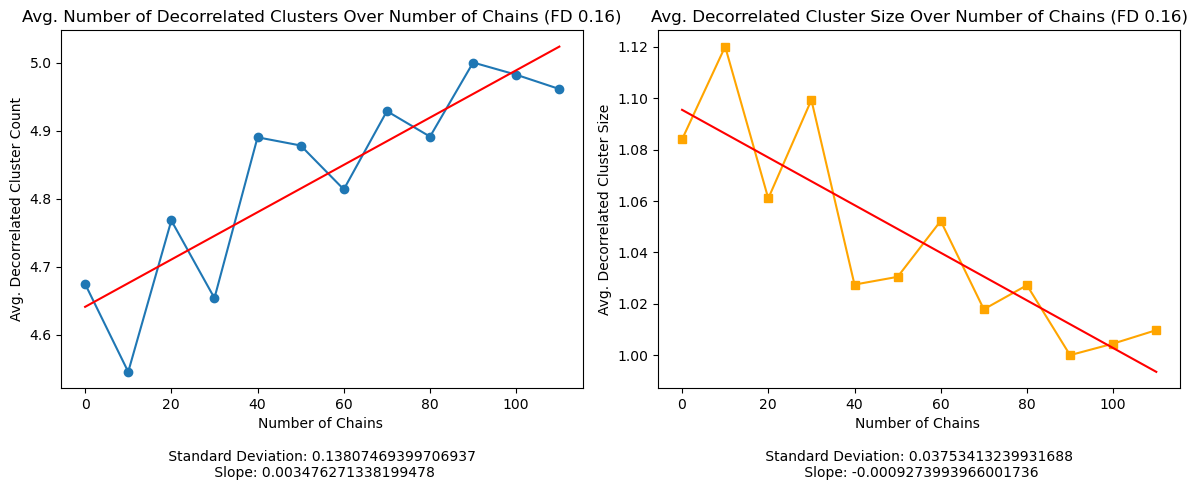

In [47]:
num_chains = 0

start_range = 0
end_range = 120
increment_value = 10

mean_dec_sizes, mean_num_dec_clusters = calculate_num_and_size_means_chains(num_chains)

num_slope, num_intercept = np.polyfit(range(start_range, end_range, increment_value), mean_num_dec_clusters, 1)
num_line_of_best_fit = num_slope * range(start_range, end_range, increment_value) + num_intercept

size_slope, size_intercept = np.polyfit(range(start_range, end_range, increment_value), mean_dec_sizes, 1)
size_line_of_best_fit = size_slope * range(start_range, end_range, increment_value) + size_intercept

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(start_range, end_range, increment_value), mean_num_dec_clusters, marker='o')
plt.plot(range(start_range, end_range, increment_value), num_line_of_best_fit, color='red')
plt.title(f"Avg. Number of Decorrelated Clusters Over Number of Chains (FD 0.16)")
plt.xlabel(f"Number of Chains \n \n Standard Deviation: {np.std(mean_num_dec_clusters)} \n Slope: {num_slope}")
plt.ylabel("Avg. Decorrelated Cluster Count")

plt.subplot(1, 2, 2)
plt.plot(range(start_range, end_range, increment_value), mean_dec_sizes, marker='s', color='orange')
plt.plot(range(start_range, end_range, increment_value), size_line_of_best_fit, color='red')
plt.title(f"Avg. Decorrelated Cluster Size Over Number of Chains (FD 0.16)")
plt.xlabel(f"Number of Chains \n \n Standard Deviation: {np.std(mean_dec_sizes)} \n Slope: {size_slope}")
plt.ylabel("Avg. Decorrelated Cluster Size")

plt.tight_layout()
plt.show()